# Simulating Stock Price Developement

## Theory

The price of today is the price of yesterday times its daily return. Since we will use log returns for the simulation, to get the real return, we need to calculate e to the power of the logarithmic return.

$
Price_{t} = Price_{t-1} * e^{r}
$

Yesterday's stock price is known, but r is a random variable. The brownian motion allows us to model that randomness. It consists of the addition of two components, the drift (approximation of future. Expected daily return of stock) and the stock's volatility.

$
drift = u - \frac{1}{2} \cdot var
$

Z corresponds to the distance between the data point and its mean within a standard normal distribution (Number of standard deviations).

$
volatility = std * Z[Rand(0;1)]
$

Therefore today's price will be:

$
Price_{t} = Price_{t-1} * e^{(u - \frac{1}{2} \cdot var) + std * Z[Rand(0;1)]}
$

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
np.set_printoptions(threshold=5)

## Fetch historical stock price data

In [2]:
stock = 'EXPE' # Indicate the symbol of the stock you want to simulate
data = pd.DataFrame() # Create empty data frame

In [3]:
# start indicates the earliest date of historical prices on yahoo 
data[stock] = wb.DataReader(stock, data_source='yahoo', start='2010-06-29')['Adj Close'] # fetch data from yahoo

In [4]:
data.tail()

,EXPE
Date,
2022-10-12,93.139999
2022-10-13,91.470001
2022-10-14,90.269997
2022-10-17,95.279999
2022-10-18,96.959999


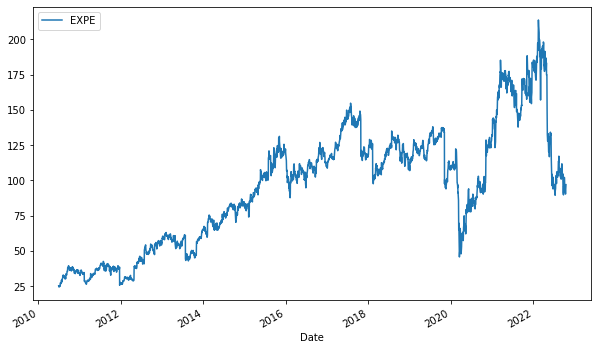

In [5]:
# Stock price developement
data.plot(figsize=(10, 6));

## Transform price data into daily returns

Share returns are continuous. Therefore we ned to take the natural logarithm. Arithmetic returns are discrete, not compounded and computed only for one single period. Since logarithmic returns are continuously compounded between the periods, the returns can be added. If we want to model retruns, we need to use the normal distribution. We cannot use simple returns, because they are not normally distributed. Log returns however, do follow a normal distribution. Log returns are symmetric and returns of equal magnitude but opposite signs will cancel each other out. Arithmetic return has a positive bias. To eliminate this bias we need to take the log return. 

In [6]:
log_returns = np.log(1+data.pct_change()) # calculate log returns

In [7]:
log_returns.tail()

,EXPE
Date,
2022-10-12,0.014274
2022-10-13,-0.018093
2022-10-14,-0.013206
2022-10-17,0.054015
2022-10-18,0.017479


<AxesSubplot:xlabel='Date'>

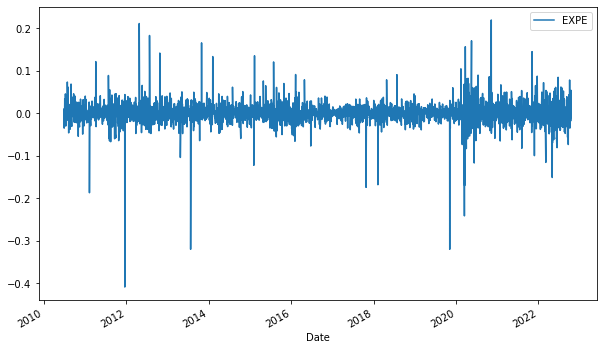

In [8]:
# Distribution of log returns
log_returns.plot(figsize=(10,6))

## Calculate drift

In [9]:
u = log_returns.mean()
u

EXPE    0.000436
dtype: float64

In [10]:
var = log_returns.var()
var

EXPE    0.000752
dtype: float64

In [11]:
drift = u - (0.5*var)
drift

EXPE    0.00006
dtype: float64

## Calculate random volatility

In [12]:
std = log_returns.std()
std

EXPE    0.027424
dtype: float64

In [13]:
# Create an array of the given shape and populate it with random samples from a uniform distribution over [0, 1).
x = np.random.rand(10, 2)
x

array([[0.18482814, 0.39219426],
       [0.05087115, 0.32468008],
       [0.18916564, 0.61102434],
       ...,
       [0.33212313, 0.58084186],
       [0.85856797, 0.61125918],
       [0.06647661, 0.86170973]])

In [14]:
# The method norm.ppf() takes a percentage and returns a standard deviation multiplier for what value that percentage occurs at.
norm.ppf(x)

array([[-0.89711738, -0.27360456],
       [-1.63646502, -0.45465124],
       [-0.88097514,  0.28198981],
       ...,
       [-0.43405808,  0.20404763],
       [ 1.07390769,  0.28260241],
       [-1.50255738,  1.088033  ]])

In [15]:
# Generate Z - Values
Z = norm.ppf(np.random.rand(10,2))
Z

array([[ 0.34889539,  0.94227459],
       [ 0.5294029 ,  0.6250815 ],
       [-1.12794844,  1.19363782],
       ...,
       [ 0.52973923, -1.66009741],
       [-0.09496721,  0.0327395 ],
       [ 0.34296218,  0.97878305]])

## Calculate daily returns

In [16]:
t_intervals = 1000 # how many days to predict
iterations = 10 #series of predictions

In [17]:
# Calculate daily arithmetic returns from random variable r
r = drift.values + std.values * norm.ppf(np.random.rand(t_intervals, iterations))
daily_returns = np.exp(r)

In [18]:
daily_returns

array([[0.99157518, 0.94020894, 1.01228843, ..., 0.99991649, 0.94993203,
        1.01792667],
       [0.97520258, 0.99980559, 1.00407037, ..., 0.96903095, 1.01934802,
        1.00238485],
       [0.97704794, 1.02022852, 1.0191803 , ..., 0.94888931, 1.00634589,
        0.96832913],
       ...,
       [1.00169941, 1.00185404, 0.94559596, ..., 1.02116234, 0.99901551,
        0.99700491],
       [1.03269073, 1.03411941, 0.97831233, ..., 1.01456162, 1.03797408,
        1.04854673],
       [1.00112245, 0.99184018, 0.99542144, ..., 1.05890803, 0.95925822,
        0.97010014]])

## Simulate stock growth

In [19]:
# Most recent stock price
S0 = data.iloc[-1]
S0

EXPE    96.959999
Name: 2022-10-18 00:00:00, dtype: float64

In [20]:
# Create empty price data frame as big as the daily returns df
price_list = np.zeros_like(daily_returns)

In [21]:
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
# Set most recent price as starting point for each iteration
price_list[0] = S0

In [23]:
# Replace 0's with expected stock prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t-1]*daily_returns[t]

In [24]:
price_list

array([[ 96.95999908,  96.95999908,  96.95999908, ...,  96.95999908,
         96.95999908,  96.95999908],
       [ 94.55564165,  96.9411492 ,  97.35466186, ...,  93.95723988,
         98.83598298,  97.19123458],
       [ 92.38539448,  98.902125  ,  99.22195395, ...,  89.15502027,
         99.46318478,  94.11310352],
       ...,
       [119.20868505,  11.26019208,  28.19151623, ..., 159.81624318,
        178.30923863,  60.42774159],
       [123.10570422,  11.64438319,  27.58010805, ..., 162.14342617,
        185.08036865,  63.3613106 ],
       [123.24388394,  11.54936706,  27.45383078, ..., 171.6949756 ,
        177.53986476,  61.46681638]])

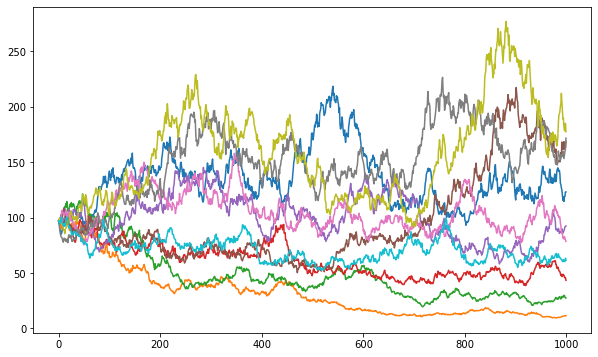

In [25]:
plt.figure(figsize=(10,6))
plt.plot(price_list);